In [1]:
# common imports 
import numpy as np 
import pandas as pd 
import os
from tqdm import tqdm
import math

#time
import time 
from datetime import datetime

# file handling
import csv

# for capturing the video / graphs
import cv2 as cv
import matplotlib.pyplot as plt 

# from sklearn imports
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

In [2]:
import pandas as pd

# pytorch imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, RandomSampler

# optimizer
from torch.optim import Adam

# Computer Vision import
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torchvision.models import  ResNet50_Weights, ResNet101_Weights, ResNet152_Weights, VGG16_Weights,VGG19_Weights

In [3]:
print(f' cuda available : {torch.cuda.is_available()} ')
print(f' device name is : {torch.cuda.get_device_name(0)}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

 cuda available : True 
 device name is : NVIDIA GeForce RTX 3050 Laptop GPU


In [4]:
def load_images(dir,batch_size=32,train=True):

    if train:

        transform = transforms.Compose([

        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        #transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
        transforms.RandomRotation(degrees=(20, 70)),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406] , std = [0.229, 0.224, 0.225] ) 

        ])

    else:

        transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406]  , std = [0.229, 0.224, 0.225] )
        ])
    
    dataset = ImageFolder( root=dir, transform=transform )
    print(dataset.class_to_idx)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle = True)

    return dataset.class_to_idx, dataloader

In [5]:
class_to_ind, train_dataloader = load_images('train')
_, val_dataloader = load_images('valid',train=False)
_, test_dataloader = load_images('test',train=False)

{'Negative': 0, 'Positive': 1}
{'Negative': 0, 'Positive': 1}
{'Negative': 0, 'Positive': 1}


In [6]:
print(f" Total images in train : {sum( len(k[0]) for k in train_dataloader )} ")
print(f" Total images in val : {sum( len(k[0]) for k in val_dataloader )} ")
print(f" Total images in test : {sum( len(k[0]) for k in test_dataloader )} ")

 Total images in train : 600 
 Total images in val : 200 
 Total images in test : 200 


In [16]:
cnn_model = models.vgg19(weights=VGG19_Weights.DEFAULT)
cnn_model.classifier = cnn_model.classifier[0]
cnn_model = cnn_model.eval().to(device)

In [347]:
cnn_model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
del cnn_model.fc
cnn_model.fc = nn.Sequential()
cnn_model = cnn_model.eval().to(device)

In [17]:
for param in cnn_model.parameters(): # freezing the grads 
    param.requires_grad = False

print(f" Total parameters in cnn_mode is : {sum(p.numel() for p in cnn_model.parameters())*1e-6:.3f}M")

 Total parameters in cnn_mode is : 122.789M


In [294]:
k = [i for i in train_dataloader]
k[0][0].shape

torch.Size([32, 3, 224, 224])

In [ ]:
%time cnn_model(k[0][0].to(device))

In [24]:
class Image_Classifier(nn.Module):
    
    def __init__(self,input_dim,output_dim=2):

        super(Image_Classifier,self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.cnn_model = cnn_model
        self.dense_layer1 = nn.Sequential(

            nn.Linear(self.input_dim, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            nn.LeakyReLU(),

            nn.Linear(256,64),
            #nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            nn.LeakyReLU(),

            nn.Linear(64,16),
            nn.BatchNorm1d(16),
            nn.Dropout(0.2),
            nn.LeakyReLU(),

            nn.Linear(16,self.output_dim),
        )
    

    def forward(self,x):

        # t1 = time.time()
        y = cnn_model(x)
        # t2 = time.time()

        # print(f" Total time for one cnn_pass : {(t2-t1)*1e3:3f} ms ")

        y = self.dense_layer1(y)
        return y

In [25]:
model = Image_Classifier(4096).to(device)
print(f' total trainable params in PPO_model is : {sum(param.numel() for param in model.parameters() if param.requires_grad)*1e-6:.3f} M')

 total trainable params in PPO_model is : 1.067 M


In [26]:
class Train_Logistic_Regression_Model():

    def __init__(self, train=train_dataloader, val=val_dataloader, 
                model = model, lr=1e-4, device=device):
        
        # moving the model to device
        self.device = device
        self.model = model.to(self.device)

        # Initializing the data
        self.train_dataloader = train
        self.val_dataloader = val

        # sizes
        self.train_size = sum( len(k[0]) for k in train_dataloader )
        self.val_size = sum( len(k[1]) for k in val_dataloader)
        self.test_size = sum( len(k[0]) for k in test_dataloader )

        # Loss function and optimizer
        self.loss = nn.CrossEntropyLoss().to(device)

        # official doc to know about parameters in Adam optimizer : https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
        self.optimizer = Adam(self.model.parameters() , lr=lr)
    
    def eval(self):
        
        y_true = []
        y_pred = []
        val_loss = 0

        for index,data in enumerate(self.val_dataloader):

            x,y = data
            x,y = x.to(device), y.to(device)
            
            pred = self.model(x) # argmax to get the index value of highest probability
            loss = self.loss(pred,y) 
            pred = torch.argmax(pred,-1)
            
            # appending them to get the f1_score after all batches
            y_true.append(y)
            y_pred.append(pred)

            val_loss += loss.item()*len(y) # multiplying by batch_size to get the total loss of the batch
        
        # joining to find the it's f1 score in overall val data
        y_pred = torch.cat(y_pred,0).detach().cpu().numpy()
        y_true = torch.cat(y_true,0).detach().cpu().numpy()

        # dividing to get the avg loss
        val_loss /= self.val_size

        # Now calculating the f1 score 
        f1 = f1_score(y_true,y_pred)

        return f1, val_loss

    
    def Train_Model(self, epochs=10, print_freq=2):

        # lists to store value and make graph in the end
        train_loss_list = []
        val_loss_list = []

        train_f1 = []
        val_f1 = []

        for epoch in range(epochs):

            y_true = []
            y_pred = []
            train_loss = 0

            for index,data in tqdm(enumerate(self.train_dataloader)):

                x,y = data
                x,y = x.to(device), y.to(device)

                pred = self.model(x) # argmax to get the index value of highest probability
                loss = self.loss(pred,y)
                pred = torch.argmax(pred,-1) 

                # Now doing the back-propagation
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
                
                # appending them to get the f1_score after all batches
                y_true.append(y)
                y_pred.append(pred)

                train_loss += loss.item()*len(y) # multiplying by batch_size to get the total loss of the batch


            # joining to find the it's f1 score in overall train data
            y_pred = torch.cat(y_pred,0).detach().cpu().numpy()
            y_true = torch.cat(y_true,0).detach().cpu().numpy()

            # Now calculating the f1 score
            f1 = f1_score(y_true,y_pred)

            # appending the calculated values to the train list
            train_loss_list.append( train_loss/ self.train_size )
            train_f1.append(f1)

            # evaluation in validation dataset
            validation_f1, val_loss = self.eval()

            # Now appending in the val list
            val_loss_list.append(val_loss)
            val_f1.append(validation_f1)

            if (epoch+1)% print_freq == 0  :

                print(f"===================================")
                print(f" The epoch is : {epoch+1} ")
                print(f" Train and val loss is : {train_loss/self.train_size:.3f} and {val_loss:.3f} ")
                print(f" Train and val f1 score is : { (f1*100):.2f} and {(validation_f1*100):.2f} ")
                print(f"=================================== \n")
            
        return train_loss_list, val_loss_list


In [27]:
trainer = Train_Logistic_Regression_Model()

In [39]:
train_loss, val_loss = trainer.Train_Model(5,5)

19it [00:11,  1.60it/s]
19it [00:11,  1.64it/s]
19it [00:11,  1.70it/s]
19it [00:11,  1.71it/s]
19it [00:11,  1.71it/s]


 The epoch is : 5 
 Train and val loss is : 0.166 and 0.277 
 Train and val f1 score is : 93.29 and 90.91 



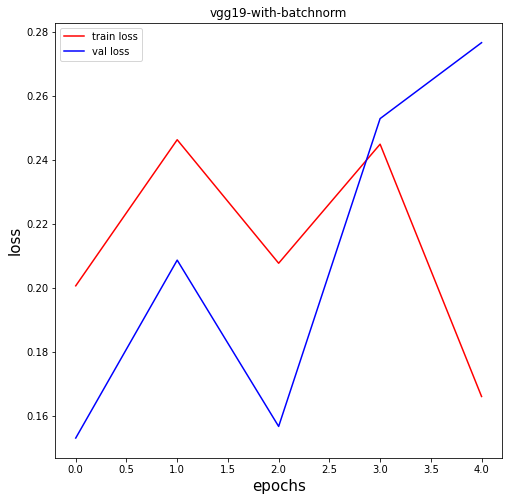

In [44]:
plt.figure(figsize=(8,8))
plt.xlabel("epochs",size=15)
plt.ylabel("loss",size=15)
plt.plot(train_loss,color='r',label='train loss')
plt.plot(val_loss,color='b',label='val loss')
plt.legend(loc='best')
plt.title('vgg19-with-batchnorm')
plt.show()

In [31]:
def test_model(test=test_dataloader, m=model):

    Loss = nn.CrossEntropyLoss().to(device)
    test_size = sum( len(k[0]) for k in test_dataloader )

    m = m.eval()
    
    y_true = []
    y_pred = []
    val_loss = 0


    with torch.no_grad():

        for index,data in tqdm(enumerate(test)):

            x,y = data
            x,y = x.to(device), y.to(device)
            
            pred = model(x) # argmax to get the index value of highest probability
            loss = Loss(pred,y) 
            pred = torch.argmax(pred,-1)
            
            # appending them to get the f1_score after all batches
            y_true.append(y)
            y_pred.append(pred)

            val_loss += loss.item()*len(y) # multiplying by batch_size to get the total loss of the batch
        
        # joining to find the it's f1 score in overall val data
        y_pred = torch.cat(y_pred,0).detach().cpu().numpy()
        y_true = torch.cat(y_true,0).detach().cpu().numpy()

        # dividing to get the avg loss
        val_loss /= test_size

        # Now calculating the f1 score 
        f1 = f1_score(y_true,y_pred)

    print(f"===================================")
    print(f" test loss is :  {val_loss:.3f} ")
    print(f" test f1 score is : {(f1*100):.2f} ")
    print(f"=================================== \n")
            

In [32]:
test_model()

7it [00:04,  1.74it/s]

 test loss is :  0.216 
 test f1 score is : 100.00 



In [42]:
def save(name,m=model):
    torch.save(m.dense_layer1.state_dict(),f'./stored_models/{name}.pt')
save('vgg19-fine-tune-dense-layer-20-iteration-20-best')

In [268]:
def load_model(name,m=model,):
    m.dense_layer1.load_state_dict(torch.load(f'./stored_models/{name}.pt',map_location=device))

load_model('vgg19-fine-tune-dense-layer')

In [35]:
index_to_class = {val:key for key,val in zip(class_to_ind.keys(),class_to_ind.values()) }

In [40]:
def predict(dir='predict', m=model, ind2c = index_to_class ):
    
    lass_to_ind, predict_dataloader = load_images('predict',train=False)

    Loss = nn.CrossEntropyLoss().to(device)
    test_size = sum( len(k[0]) for k in predict_dataloader )

    m = m.eval()

    y_pred = []
    confidence = []
    pred_loss = 0


    with torch.no_grad():

        for index,data in tqdm(enumerate(predict_dataloader)):

            x,y = data
            x,y = x.to(device), y.to(device)
            
            pred = model(x) # argmax to get the index value of highest probability
            loss = Loss(pred,y) 
            pred_ind = torch.argmax(pred,-1)
            conf = torch.max(torch.softmax(pred,-1),-1).values
            # print(conf,pred)
            
            # appending them to get the f1_score after all batches
            y_pred.append(pred_ind)
            confidence.append(conf)

            pred_loss += loss.item()*len(y) # multiplying by batch_size to get the total loss of the batch
        
        # joining to find the it's f1 score in overall val data
        conf = torch.cat(confidence,0).detach().cpu().numpy()
        y_pred = [index_to_class[k] for k in  torch.cat(y_pred,0).detach().cpu().numpy()]

        # dividing to get the avg loss
        pred_loss /= test_size

        print([i for i in zip(y_pred,conf)])
        return y_pred,conf

In [41]:
prediction,conf = predict()

{'negative': 0}


1it [00:01,  1.41s/it]

[('Positive', 0.5615616), ('Negative', 0.65020984), ('Negative', 0.645092), ('Negative', 0.69503385), ('Positive', 0.5832951), ('Negative', 0.6764064)]


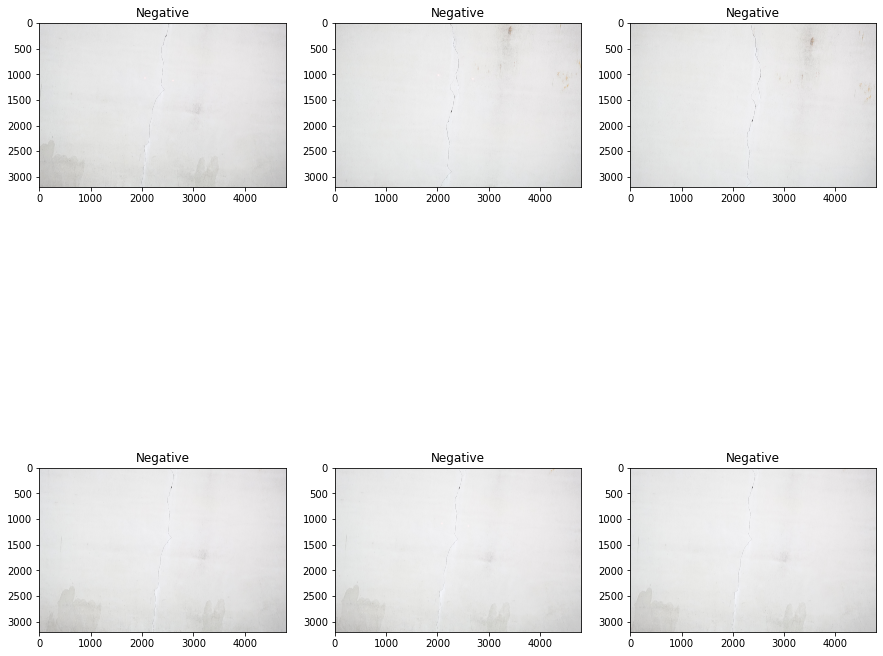

In [38]:
from PIL import Image
plt.figure(figsize=(15,15))
for i,file in enumerate(os.listdir('predict/negative')):
    path = 'predict/negative/' + f'{file}'
    img = np.array(Image.open(path))
    plt.subplot(2,3,i+1)
    plt.imshow(img)
    plt.title(prediction[i])
plt.show()

In [43]:
name = 'vgg-19-best'
df_prediction = pd.DataFrame({'prediction':prediction,'confidence':conf*100})
df_prediction.to_csv(f'./prediction/{name}.csv')
df_prediction.head()


,prediction,confidence
0,Positive,56.156158
1,Negative,65.020981
2,Negative,64.509201
3,Negative,69.503387
4,Positive,58.329510
